# FITS Catalogs in Python

Let's ignore, for now, the details of we build astronomical catalogs, and start with one that's already been created.  This is included in the GitHub repo (if you don't have it checked out, you can find it [here](https://github.com/timothydmorton/usrp-sciprog/blob/master/data/HSC_grizy_example.fits)).  It's in a very common astronomical file format called FITS.  It's an old format, and it's showing its age in a lot of ways, but it's still pretty capable.

Each FITS file has multiple "Header/Data Units" (HDUs), each of which contains a header (a list of key/value pairs, like a somwhat clunky Python dict), and some binary data (which we'll read into NumPy arrays).

We can load a FITS file using the astropy package, which should have been installed as part of anaconda:

In [1]:
import astropy.io.fits
import numpy
fits = astropy.io.fits.open("../data/HSC_grizy_example.fits")

The object we get back (called `fits` here) is a special kind of list, with each item an HDU:

In [2]:
len(fits)

2

But this file is only supposed to include one table - let's see what's going on by looking at the header of the first (0th) HDU:

In [3]:
fits[0].header

SIMPLE  =                    T /Dummy Created by MWRFITS v1.11a                 
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               

There's not much here, but the important piece of information is that `NAXIS=0` - that means the data array has zero dimensions.  This is one of the weird historical artifacts of the FITS standard: we're not allowed to put a binary table in the first HDU, so there's an empty dummy HDU there instead.  The next HDU is the one we want.  You can look at its header if you'd like to see what it looks like on disk, but astropy uses everything there to create its view of the data part of HDU, so we can just look at that:

In [4]:
table = fits[1].data

I said this would be a numpy.ndarray, but if we look at its type, we can see that it isn't, at least not exactly:

In [9]:
type(table)

astropy.io.fits.fitsrec.FITS_rec

It's actually a new type that *inherits* from `numpy.ndarray`, which we can verify like this:

In [10]:
isinstance(table, numpy.ndarray)

True

### Field Names and Types

This is a strange array: instead of just being a 1-d array of simple numbers, or a 2-d array of simple numbers, it's a table: a 1-d array where each column can have a different type.  We can look at that type by looking at the `dtype` property:

In [11]:
a = numpy.array([1,2,3])
a.dtype

dtype('int64')

In [7]:
table.dtype

dtype([('ID', '>i8'), ('RA', '>f8'), ('DC', '>f8'), ('PARENT', '>i8'), ('DEBLEND_NCHILD', '>i4'), ('G_SHAPE_SDSS', '>f8', (3,)), ('G_FLUX_KRON_RADIUS', '>f8'), ('G_FLUX_KRON', '>f8'), ('G_FLUX_KRON_ERR', '>f8'), ('G_FLUX_PSF', '>f8'), ('G_FLUX_PSF_ERR', '>f8'), ('G_FLUX_SINC', '>f8'), ('G_FLUX_SINC_ERR', '>f8'), ('R_SHAPE_SDSS', '>f8', (3,)), ('R_FLUX_KRON_RADIUS', '>f8'), ('R_FLUX_KRON', '>f8'), ('R_FLUX_KRON_ERR', '>f8'), ('R_FLUX_PSF', '>f8'), ('R_FLUX_PSF_ERR', '>f8'), ('R_FLUX_SINC', '>f8'), ('R_FLUX_SINC_ERR', '>f8'), ('I_SHAPE_SDSS', '>f8', (3,)), ('I_FLUX_KRON_RADIUS', '>f8'), ('I_FLUX_KRON', '>f8'), ('I_FLUX_KRON_ERR', '>f8'), ('I_FLUX_PSF', '>f8'), ('I_FLUX_PSF_ERR', '>f8'), ('I_FLUX_SINC', '>f8'), ('I_FLUX_SINC_ERR', '>f8'), ('Z_SHAPE_SDSS', '>f8', (3,)), ('Z_FLUX_KRON_RADIUS', '>f8'), ('Z_FLUX_KRON', '>f8'), ('Z_FLUX_KRON_ERR', '>f8'), ('Z_FLUX_PSF', '>f8'), ('Z_FLUX_PSF_ERR', '>f8'), ('Z_FLUX_SINC', '>f8'), ('Z_FLUX_SINC_ERR', '>f8'), ('Y_SHAPE_SDSS', '>f8', (3,)), ('Y_FLU

It's a bit of a mess to read, but you can see that it's like a list (name, type) pairs, one for each column.  The types strings use a code system common to all NumPy arrays.  I won't go into the details, but:
 - `>f8` is a floating point number taking up 8 bytes
 - `>i4` is an integer taking up 4 bytes

But some of the fields are a little weirder; let's take a look at the type of "R_SHAPE_SDSS":

In [27]:
table.dtype["R_SHAPE_SDSS"]

dtype(('>f8', (3,)))

This means the column is actually 3 columns that are grouped together, each one an 8-byte floating point number.  In this case, those three numbers are the parameters of an ellipse that roughly measures the shape and size of the object - but we'll get back to that in a future lesson.

### Row Access

We can iterate over a table's rows (also called "records") as we would any other Python sequence, then access the elements of each row as if it were a `dict`:

In [29]:
for record in table[:5]:
    print("r={r}, i={i}".format(r=record["R_FLUX_KRON"], i=record["I_FLUX_KRON"]))

r=876.988301094, i=713.24841364
r=11.4040837855, i=8.52686826792
r=312.932101173, i=238.390369401
r=23.0117455662, i=12.980668159
r=11.0797875288, i=7.79981187479


Note that we've used regular array slicing to limit the iteration to the first 5 rows, just as we would with a regular 1-d array.

### Column Access and Indexing

More frequently, we'll want to access tables by column, which will give us a regular 1-d array for that column, which we can then plot.  To get column arrays, we can just treat the table like a `dict`.  Here's a histogram of flux values in the *r*-band:

AttributeError: max must be larger than min in range parameter.

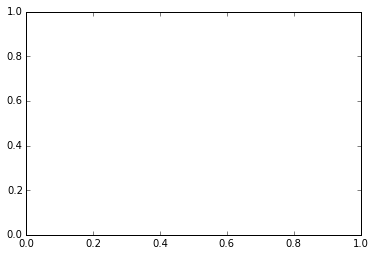

In [8]:
from matplotlib import pyplot
%matplotlib inline
pyplot.hist(table["R_FLUX_KRON"], bins=50)

So, that didn't work.  The reason is that some of the elements in the array are "NaN", which means "Not a Number":

In [35]:
table["R_FLUX_KRON"].min()

nan

NaN is a special value that floating point numbers can have that's used when an expression doesn't have a meaningful result, or one that can't be expressed with regular floating point numbers.  For instance:

In [37]:
numpy.sqrt(-1.0)

-c:1: RuntimeWarning: invalid value encountered in sqrt


nan

The table here has NaNs because the algorithms used to measure some of the quantities failed for some objects.  This is completely normal - it's rare to find an astronomical catalog that doesn't contain a few garbage objects initially, or at least some objects so faint we couldn't measure them well.  For now we just want to remove them from the catalog, because (as we've seen) NaNs cause all kinds of problems:

In [38]:
5 < float("NaN") or 5 >= float("NaN")   # this means we can't sort NaNs, as we'd need to to make a histogram

False

In [39]:
3.1 + float("NaN")  # NaNs are infectious: any operation involving them returns a NaN

nan

So, how do we remove them?  First we can identify them with the numpy function `isnan`:

In [40]:
numpy.isnan(table["R_FLUX_KRON"])

array([False, False, False, ..., False, False, False], dtype=bool)

The result is an array with that's `False` for every row that isn't NaN, and `True` for each one that is (we can't see any here because the result is abbreviated - but even one NaN will cause problems).  But we want the opposite of this: we want an array that's `True` for elements that aren't NaN.  For that, we can use `numpy.logical_not`:

In [42]:
mask = numpy.logical_not(numpy.isnan(table["R_FLUX_KRON"]))

We can now use this to get a subset of the table that only includes rows where the flux is not NaN, and make our histogram:

(array([  3.89100000e+03,   1.60000000e+01,   4.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

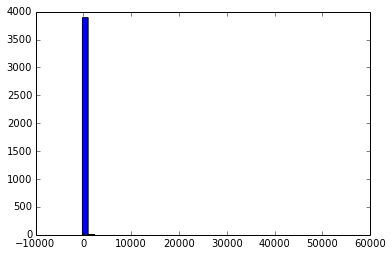

In [50]:
subset = table[mask]
pyplot.hist(subset["R_FLUX_KRON"], bins=50)

It's not a very interesting plot, because the distribution is very steep, but we'll leave fixing that to an exercise.